Setup on IPP Prague abacus - *TO BE RUN BEFORE JUPYTER NOTEBOOK START*
```
module load matlab/2016a
module load python3 matlab-python-engine/2016a/python3/anaconda
source activate global_opt
export LD_LIBRARY_PATH=/sw/python2/anaconda3/envs/global_opt/lib/:/sw/matlab/r2016a/sys/os/glnxa64/

export PYTHONPATH=/compass/home/urban/projects/cronos/metis-git/python:$PYTHONPATH
export MATLABPATH=/compass/home/urban/projects/cronos/metis-git:$MATLABPATH
```

# Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.constants
import matplotlib.pyplot as plt
import importlib
import itertools
import operator
import copy
import seaborn as sns

/sw/python2/anaconda3/envs/global_opt/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
import pydons
import dill
import pandas as pd

This is the most important import - the `pymetis` module.

In [4]:
import pymetis
from pymetis import MetisX, apply_waveform
from optimize_util import Constraint

We can easily check the path to METIS (and also the MATLAB engine)

In [5]:
pymetis.engine().which('metis')

'/compass/home/urban/projects/cronos/metis-git/metis.m'

# Input data

In [6]:
# the path to the reference METIS data file
input_data_file = '/compass/home/urban/workspace/freebie-metis/demo_reactor_2.mat'

In [7]:
# read the mat file using pydons
input_data = pydons.MatStruct.loadmat(input_data_file, 'post')
z0dinput = input_data.post.z0dinput
post0 = input_data.post

# Optimizer setup

## The interface function

The interface function maps an input vector x to a `z0input` structure. The first parameter must be z0dinput, which is modified by the function and returned. Other arguments are arbitrarily named components of the x-vector, i.e. the optimization parameters.

In [8]:
def x2metis_demo_1(z0dinput, t_ramp_up, qcyl, B0, R0, A, elong, triang, f_Gw, 
                   Pnbi, Enbi, atang, PEC0, PEC1, XEC0, XEC1):

    times = np.atleast_1d(np.array((z0dinput.cons.temps[0].squeeze(), 
                                    t_ramp_up, 
                                    z0dinput.cons.temps[-1].squeeze())))
     
    # minor radius
    a0 = R0 / A
    mu0 = scipy.constants.mu_0
    # fix the initial current to 0.5 MA
    Ip0 = 0.5e6
    # flat-top current, approximate Ip from ~qcyl
    Ip = (2 * np.pi * a0**2 * elong * B0) / (qcyl * mu0 * R0)
#     print(Ip)
    Ip_t = np.array((Ip0, Ip, Ip))
    z0dinput.cons.ip = apply_waveform(z0dinput.cons.temps, z0dinput.cons.ip, times, Ip_t)
    
    # apply waveforms
    z0dinput.geo.b0 = B0 * np.ones_like(z0dinput.geo.b0)
    z0dinput.geo.R = R0 * np.ones_like(z0dinput.geo.R)
    a_t = np.array((0.5 * a0, a0, a0))
    z0dinput.geo.a = apply_waveform(z0dinput.cons.temps, z0dinput.geo.a, times, a_t)
    # assume constant shaping for the moment
    z0dinput.geo.K = elong * np.ones_like(z0dinput.geo.K)
    z0dinput.geo.d = triang * np.ones_like(z0dinput.geo.d)

#     # shaping ramp
#     elong_t = np.array((1, elong, elong))
#     z0dinput.geo.K = apply_waveform(z0dinput.cons.temps, z0dinput.geo.elong, times, elong)
#     elong_t = np.array((1, triang, triang))
#     z0dinput.geo.d = apply_waveform(z0dinput.cons.temps, z0dinput.geo.d, times, triang)
    
    # Greenwald density
    # n_Gw = 1e20 * Ip*1e-6 / a**2
    # density from Gw fraction
    z0dinput.cons.nbar = f_Gw * 1e20 * z0dinput.cons.ip*1e-6 / (np.pi * z0dinput.geo.a**2)
    
    Pnbi_t = np.array((0, Pnbi, Pnbi))
    # divede to two nbi's
    z0dinput.cons.pnbi = (0.5 + 0.5j) * apply_waveform(z0dinput.cons.temps, z0dinput.cons.pnbi, times, Pnbi_t)
    z0dinput.option.einj = float(Enbi)
    z0dinput.option.einj2 = float(Enbi)
    z0dinput.option.rtang = float(R0 + atang * a0)
    z0dinput.option.rtang2 = float(z0dinput.option.rtang)
    # ECRH applied during the ramp-up
    times_ec = np.array((times[0], times[1], times[1] + 10, times[-1]))
    PEC_t = np.array((PEC0, PEC1, 0, 0))
    XEC_t = np.array((XEC0, XEC1, XEC1, XEC1))
    z0dinput.cons.pecrh = apply_waveform(z0dinput.cons.temps, z0dinput.cons.pecrh, times_ec, PEC_t)
    z0dinput.cons.xece = apply_waveform(z0dinput.cons.temps, z0dinput.cons.pecrh, times_ec, XEC_t)
    
    return z0dinput
    

We can test the interface function, e.g. by plotting the Ip reference.

In [9]:
z0dinput = x2metis_demo_1(z0dinput, t_ramp_up=135, qcyl=2.5, B0=6, R0=8.8, A=2.8, elong=1.5, triang=0.2, f_Gw=0.9, 
                   Pnbi=50e6, Enbi=1.5e6, atang=0.2, PEC0=0, PEC1=50e6, XEC0=0, XEC1=0.7)

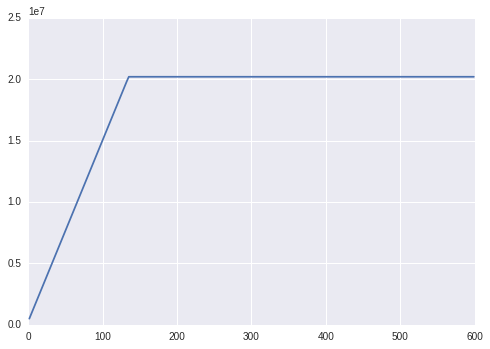

In [10]:
plt.plot(z0dinput.cons.temps, np.real(z0dinput.cons.ip))

## Objective functions

The objective function input parameter is a `post` METIS structure, i.e. all inputs and outputs.

In [47]:
import optimize_util

In [48]:
def obj_flux(post):
    return - optimize_util.J_flux(post, maxval=np.inf)


def obj_sq(post):
    return - optimize_util.J_Dongen(post, nu_ss=0)

In [12]:
def obj_ialign(post):
    return np.squeeze(post.zerod.ialign[-1].squeeze())[()]

In [13]:
def obj_q95(post):
    return np.squeeze(post.zerod.q95[-1].squeeze())[()]

In [14]:
def obj_Pfusion(post):
    return np.squeeze(post.zerod.pfus[-1].squeeze())[()]

In [15]:
def obj_Qfact(post):
    # from z0plotc
    cons = post.z0dinput.cons
    rfan = (3.56e6 + 14.03e6) / 3.56e6
    padd = (cons.picrh[-1] + cons.pecrh[-1] + np.real(cons.pnbi[-1]) + np.imag(cons.pnbi[-1]) + 
            post.zerod.pohm[-1] + post.zerod.plh[-1]);
    return np.squeeze(rfan * post.zerod.pfus[-1] / padd[-1])[()]

In [16]:
_z0fluxconsum = pymetis.matfunc2py('z0fluxconsum', bridge=None, nargout=4)

def obj_flux(post, type='cs'):
    
    
    
    flux_tot, flux_cs, flux_plasma_tot, flux_res = _z0fluxconsum(
        post.z0dinput, post.zerod, post.profil0d)

    if type == 'cs':
        tot = flux_cs.squeeze()[-1]    
    elif type == 'tot':
        tot = flux_tot.squeeze()[-1]
    else:
        raise ValueError('type {} unknown'.format(type))

    return - tot


## Contruct a METIS object wrapper for the optimizer

We now instantiate a MetisX object, which will provide the interface for the optimizer.
If there's enough RAM we can uses `memcache`, otherwise we can provide a `cachedir` for joblib memoize.
`matlab_bridge=None` will try to initialize the MATLAB engine (native preferred, mlabbridge as alternative).

In [17]:
xmetis = MetisX(input_data_file,
                x2metis_demo_1,
                obj_func=obj_Qfact,
                obj_func_inp=None,
                obj_func_limits=(-np.inf, np.inf),
                fast=True,
                memcache=True,
                cachedir=None,
                matlab_bridge=None)

Let's test the interface and the memcache.

In [18]:
# a simple test - should run METIS
post = xmetis(t_ramp_up=135, qcyl=2.5, B0=6, R0=8.5, A=2.8, elong=1.5, triang=0.2, f_Gw=0.9, 
                   Pnbi=50e6, Enbi=1.5e6, atang=0.2, PEC0=0, PEC1=50e6, XEC0=0, XEC1=0.7, return_post=True)

Mem-cached the result, cache size: 1


This should be emmediate thanks to the mem-cache.

In [19]:
xmetis(t_ramp_up=135, qcyl=2.5, B0=6, R0=8.5, A=2.8, elong=1.5, triang=0.2, f_Gw=0.9, 
                   Pnbi=50e6, Enbi=1.5e6, atang=0.2, PEC0=0, PEC1=50e6, XEC0=0, XEC1=0.7)

Result loaded from mem cache :-]


15.522470048055771

And this number should be exactly the same as the previous one

In [20]:
obj_Qfact(post)

15.522470048055771

We can also list the mem-cached results

In [21]:
list(xmetis._cached_results.keys())

[((),
  frozenset({('A', 2.8),
             ('B0', 6),
             ('Enbi', 1500000.0),
             ('PEC0', 0),
             ('PEC1', 50000000.0),
             ('Pnbi', 50000000.0),
             ('R0', 8.5),
             ('XEC0', 0),
             ('XEC1', 0.7),
             ('atang', 0.2),
             ('elong', 1.5),
             ('f_Gw', 0.9),
             ('qcyl', 2.5),
             ('t_ramp_up', 135),
             ('triang', 0.2)}),
  True,
  True)]

# Bayesian optimizatin

We are using a relatively simply Bayesian optimization tool from https://github.com/fmfn/BayesianOptimization

In [22]:
from bayes_opt import BayesianOptimization

We have to set limits on the optimization parameters.

## Optimization setup

In [23]:
x_limits = dict(t_ramp_up=(80, 150), 
                qcyl=(2, 3), 
                B0=(5, 10), 
                R0=(7, 10), 
                A=(2.5, 3.5), 
                elong=(1.4, 2), 
                triang=(0.2, 0.6), 
                f_Gw=(0.8, 1.1), 
                Pnbi=(20e6, 100e6), 
                Enbi=(0.5e6, 1.5e6), 
                atang=(0, 0.6), 
                PEC0=(0, 1e6), 
                PEC1=(10e6, 50e6), 
                XEC0=(0, 0.8), 
                XEC1=(0, 0.8))
x_limits

{'A': (2.5, 3.5),
 'B0': (5, 10),
 'Enbi': (500000.0, 1500000.0),
 'PEC0': (0, 1000000.0),
 'PEC1': (10000000.0, 50000000.0),
 'Pnbi': (20000000.0, 100000000.0),
 'R0': (7, 10),
 'XEC0': (0, 0.8),
 'XEC1': (0, 0.8),
 'atang': (0, 0.6),
 'elong': (1.4, 2),
 'f_Gw': (0.8, 1.1),
 'qcyl': (2, 3),
 't_ramp_up': (80, 150),
 'triang': (0.2, 0.6)}

Now, instantiate the optimizer and set the acquisition function type (and parameters if any).
We can also set parameters for the Gaussian process, the default ones seem to work fine though.

In [24]:
bo = BayesianOptimization(xmetis, x_limits)

In [25]:
bo_params = {'acq': 'ei'}
gp_params = {}

In [26]:
# update GP parameters (no need for this if gp_params are empty)
bo_params.update(gp_params)

## Start the optimization

Here we start with some number of random init points and a fixed number of iterations.

In [27]:
bo.maximize(init_points=20, n_iter=20, **bo_params)

Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |         A |        B0 |      Enbi |      PEC0 |      PEC1 |      Pnbi |        R0 |      XEC0 |      XEC1 |     atang |     elong |      f_Gw |      qcyl |   t_ramp_up |    triang | 
Mem-cached the result, cache size: 2
    1 | 00m22s |   21.14340 |    2.5491 |    5.4861 | 640800.2455 | 926377.3043 | 28803890.7796 | 34944158.3346 |    8.3509 |    0.7344 |    0.4397 |    0.5871 |    1.6180 |    0.8307 |    2.6332 |     86.4175 |    0.2084 | 
Mem-cached the result, cache size: 3
    2 | 00m21s |   29.25258 |    3.4095 |    5.8384 | 786813.0397 | 213259.6817 | 11730558.4731 | 28217808.0144 |    9.2605 |    0.1565 |    0.7217 |    0.2418 |    1.9303 |    0.9027 |    2.6141 |     90.6681 |    0.3585 | 
Mem-cached the result, cache size: 4

More steps can simply be done by calling the same method.

In [28]:
bo.maximize(init_points=2, n_iter=2, **bo_params)

Bayesian Optimization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |         A |        B0 |      Enbi |      PEC0 |      PEC1 |      Pnbi |        R0 |      XEC0 |      XEC1 |     atang |     elong |      f_Gw |      qcyl |   t_ramp_up |    triang | 
Mem-cached the result, cache size: 42
   41 | 00m29s |   10.41277 |    3.2815 |    9.5069 | 1363627.6196 | 46662.8646 | 48269328.1733 | 83357498.0844 |    7.2179 |    0.1735 |    0.2525 |    0.4130 |    1.5923 |    0.9360 |    2.4375 |    148.9015 |    0.3459 | 
Mem-cached the result, cache size: 43
   42 | 00m37s |    4.93260 |    3.0413 |    5.1392 | 857187.2403 | 775906.2621 | 29022343.6592 | 31858100.3322 |    8.9225 |    0.4978 |    0.6935 |    0.3672 |    1.7009 |    0.9506 |    2.9211 |    115.4769 |    0.3822 | 


# Results

In [29]:
# the best result
bo.res['max']

{'max_params': {'A': 2.9511300070452089,
  'B0': 5.3080971563392101,
  'Enbi': 875037.74896413099,
  'PEC0': 208718.57197499101,
  'PEC1': 47442339.454089612,
  'Pnbi': 21980940.339550186,
  'R0': 9.2429663897296841,
  'XEC0': 0.51187340522679869,
  'XEC1': 0.69845833692627179,
  'atang': 0.12420824088991184,
  'elong': 1.9599362261079873,
  'f_Gw': 1.0800291109110671,
  'qcyl': 2.4894939151215429,
  't_ramp_up': 116.28394486310783,
  'triang': 0.23755276465586972},
 'max_val': 60.590365301324979}

We can simply plot the objective function value vs the iteration number (in fact this plot includes the random data as well)

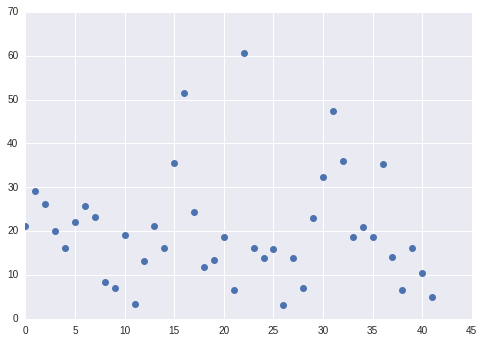

In [30]:
plt.plot(bo.Y, 'o')

Or we can simply get top 5 results like this

In [31]:
res_sorted = sorted(zip(bo.res['all']['values'], bo.res['all']['params']), key=lambda x: x[0], reverse=True)

In [32]:
top5 = list(itertools.islice(res_sorted, 0, 5))

Whole METIS (post) results can be obtained instantly from the cache

In [33]:
posts5 = [xmetis(return_post=True, **r[1]) for r in top5]

Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]


In [56]:
# we can save post structs to a mat file
# posts5mat = pydons.MatStruct(dict(top5=posts5))
# posts5mat.savemat('demo_2_top5.mat')

## Pandas
Let's analyze the data using Pandas

In [34]:
# DataFrame object
df = pd.DataFrame(bo.res['all']['params'])

In [40]:
# all post structs (excluding random generated points)
posts_df = [xmetis(return_post=True, **p) for p in bo.res['all']['params']]

Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]


Add the Q column

In [36]:
df['Q'] = bo.res['all']['values']

In [37]:
# change some units
df.PEC1 = 1e-6 * df.PEC1
df.PEC0 = 1e-6 * df.PEC0
df.Pnbi = 1e-6 * df.Pnbi
df.Enbi = 1e-6 * df.Enbi

Use Pandas `.head()` and `.describe()` for an overview

In [38]:
df.head()

,A,B0,Enbi,PEC0,PEC1,Pnbi,R0,XEC0,XEC1,atang,elong,f_Gw,qcyl,t_ramp_up,triang,Q
0,2.853026,9.046457,1.467748,0.225870,33.751137,51.795663,9.109785,0.468665,0.488700,0.142185,1.437379,0.804661,2.092835,120.591051,0.446586,18.751362
1,3.202421,5.649489,0.857265,0.807386,40.552486,94.168569,9.258905,0.247344,0.159572,0.579126,1.553925,1.027470,2.899082,132.141378,0.525004,6.676738
2,2.951130,5.308097,0.875038,0.208719,47.442339,21.980940,9.242966,0.511873,0.698458,0.124208,1.959936,1.080029,2.489494,116.283945,0.237553,60.590365
3,2.962617,8.309313,0.819339,0.774340,32.476819,91.750665,7.918956,0.132452,0.791970,0.163505,1.608820,1.073537,2.749914,114.186676,0.261025,16.154033
4,2.670748,5.162545,1.155966,0.631883,28.216079,68.013921,7.316302,0.236774,0.428695,0.272224,1.677093,0.950746,2.390960,110.381403,0.285628,13.955935


In [39]:
df.describe()

,A,B0,Enbi,PEC0,PEC1,Pnbi,R0,XEC0,XEC1,atang,elong,f_Gw,qcyl,t_ramp_up,triang,Q
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,3.018657,7.486660,1.094085,0.570536,33.497885,63.961950,8.411500,0.401500,0.443120,0.298385,1.674939,0.951325,2.634158,121.528547,0.408064,20.023706
std,0.301266,1.698041,0.319092,0.328236,11.148262,26.204644,0.903732,0.192966,0.292876,0.160657,0.156296,0.093841,0.264280,16.471009,0.124051,14.385587
min,2.516570,5.038225,0.540460,0.046663,12.055283,21.980940,7.083787,0.002442,0.005066,0.049087,1.422168,0.802408,2.092835,86.701240,0.218432,3.070105
25%,2.735327,5.821576,0.857207,0.263794,26.154043,33.575481,7.690693,0.239416,0.166769,0.169926,1.561142,0.875692,2.417612,110.396700,0.294747,11.262971
50%,3.000448,8.042118,1.114857,0.663291,32.813721,74.829463,8.209982,0.437124,0.474409,0.280266,1.679187,0.948512,2.732271,117.075435,0.430112,16.204199
75%,3.319060,8.827735,1.362199,0.824750,42.985036,86.541064,9.217942,0.508356,0.724933,0.402655,1.771575,1.028372,2.857175,133.931179,0.517043,22.439979
max,3.437218,9.971841,1.499636,0.982639,48.269328,94.168569,9.983226,0.794286,0.791970,0.579126,1.959936,1.094489,2.941331,149.105571,0.580723,60.590365


## Plotting

We'll use [`seaborn`](https://seaborn.pydata.org)

In [41]:
sns.set_context("notebook", font_scale=1.0)

Pick the variables to plot

In [43]:
plt_fields = ["B0", "R0", "Q", "qcyl"]
x_vars = list(df.columns)
x_vars.remove('Q')

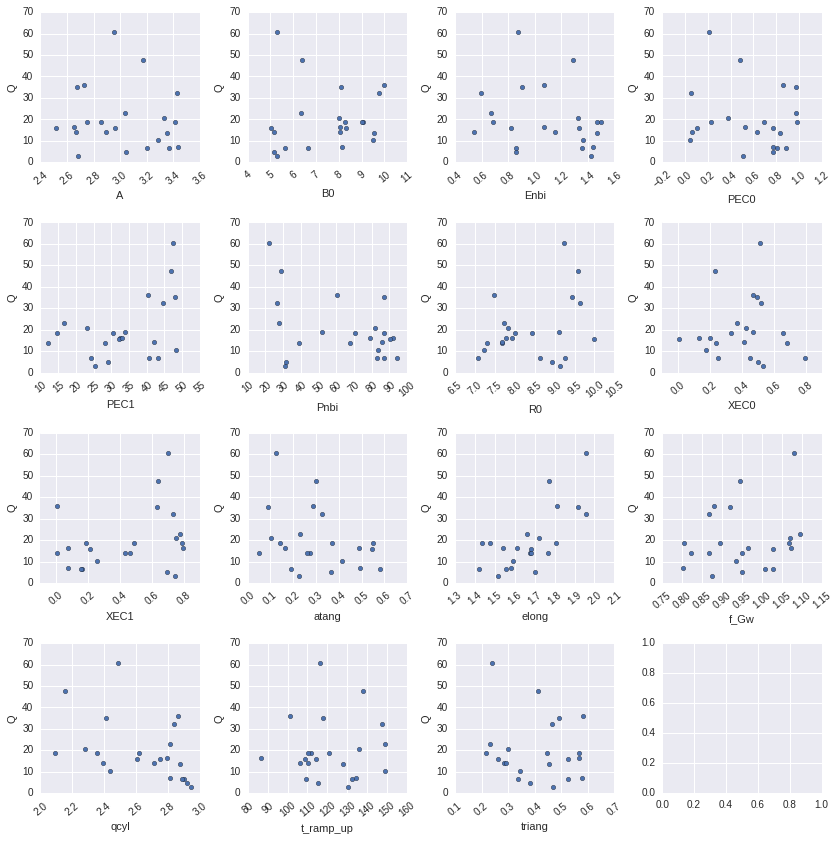

In [44]:
fig, axes = plt.subplots(int(np.ceil(len(x_vars) / 4)), 4, figsize=(14, 14))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
for ax, x in zip(axes.flat, x_vars):
    df.plot.scatter(x=x, y='Q', ax=ax)
# for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)

# Work out new objective / contraints

We first add prospective objective into the Pandas DataFrame object

In [49]:
df_new_objs = {
    's_q': obj_sq,
    'I_align': obj_ialign,
#     'flux': obj_flux,
    'P_fusion': obj_Pfusion,
}

In [50]:
# new_objs = {}
for name, func in df_new_objs.items():
    values = []
    for row, post in zip(df.iterrows(), posts_df):
#         params = row[1].to_dict()
        values.append(func(post))
#         print('.', end="")
    df[name] = values


In [51]:
df.head()

,A,B0,Enbi,PEC0,PEC1,Pnbi,R0,XEC0,XEC1,atang,elong,f_Gw,qcyl,t_ramp_up,triang,Q,I_align,s_q,P_fusion
0,2.853026,9.046457,1.467748,0.225870,33.751137,51.795663,9.109785,0.468665,0.488700,0.142185,1.437379,0.804661,2.092835,120.591051,0.446586,18.751362,0.116367,0.763088,2.227423e+08
1,3.202421,5.649489,0.857265,0.807386,40.552486,94.168569,9.258905,0.247344,0.159572,0.579126,1.553925,1.027470,2.899082,132.141378,0.525004,6.676738,0.534148,0.076341,1.280387e+08
2,2.951130,5.308097,0.875038,0.208719,47.442339,21.980940,9.242966,0.511873,0.698458,0.124208,1.959936,1.080029,2.489494,116.283945,0.237553,60.590365,0.293072,0.256742,3.024883e+08
3,2.962617,8.309313,0.819339,0.774340,32.476819,91.750665,7.918956,0.132452,0.791970,0.163505,1.608820,1.073537,2.749914,114.186676,0.261025,16.154033,0.417041,0.283893,3.162983e+08
4,2.670748,5.162545,1.155966,0.631883,28.216079,68.013921,7.316302,0.236774,0.428695,0.272224,1.677093,0.950746,2.390960,110.381403,0.285628,13.955935,0.431171,0.340723,1.965655e+08


Let's plot a pair grid of objectives / constraints

In [52]:
rows_obj = ['Q', 'P_fusion', 's_q', 'I_align']  #, 'flux']

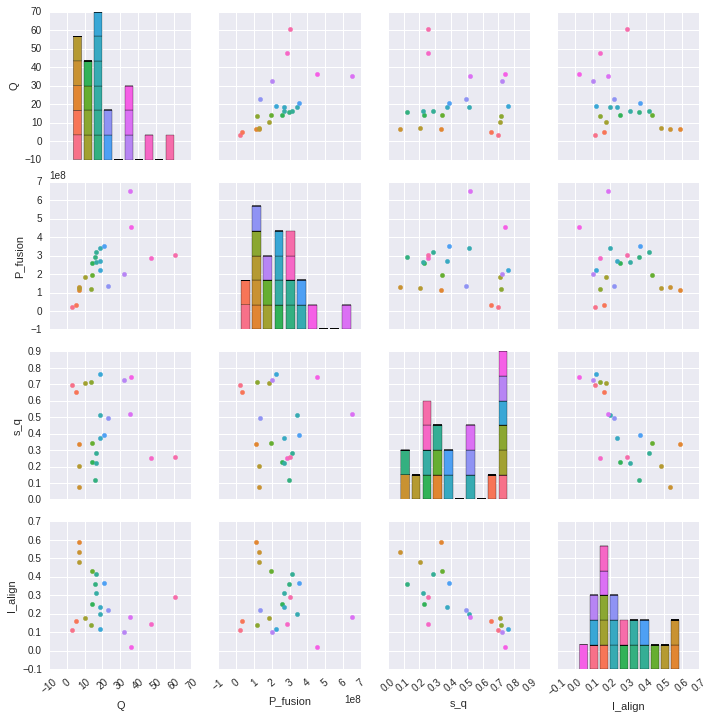

In [53]:
# with sns.plotting_context("talk"):
g = sns.PairGrid(df, vars=rows_obj, hue="Q",  
                 # palette=sns.color_palette("coolwarm", 14),
                 )
# g.map(plt.scatter)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
# g.set_xticklabels(rotation=30)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)

## Redesign objective

At this point we have optimized for the objective specified above. Yet we're not happy with the result - perhaps a constraint is missing or we would like to add anther objective.

First we use the (simple) `Contraint` class to create penalty functions.

In [60]:
cons_Q = Constraint(obj_Qfact, fmin=50)

In [61]:
cons_Pfus = Constraint(obj_Pfusion, fmin=3e8, mult=1e-7)

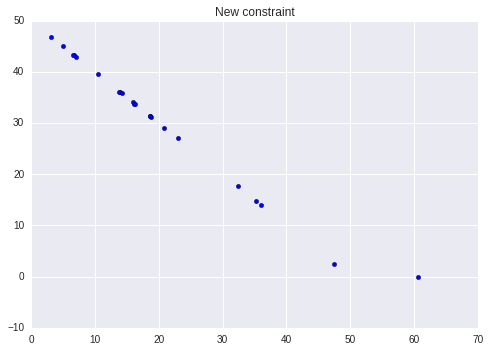

In [62]:
cons = cons_Q

x = [cons.func(p) for p in posts_df]
vals = [cons(p) for p in posts_df]
plt.scatter(x, vals)
plt.title('New constraint')

In [64]:
# out new objective function with a constraint

def obj_P_QCons(post):
    penalty = cons_Q(post)
    obj = 1e-8 * obj_Pfusion(post)
    res = obj - penalty
    
    return res

In [65]:
df['new_obj'] = [obj_P_QCons(p) for p in posts_df]

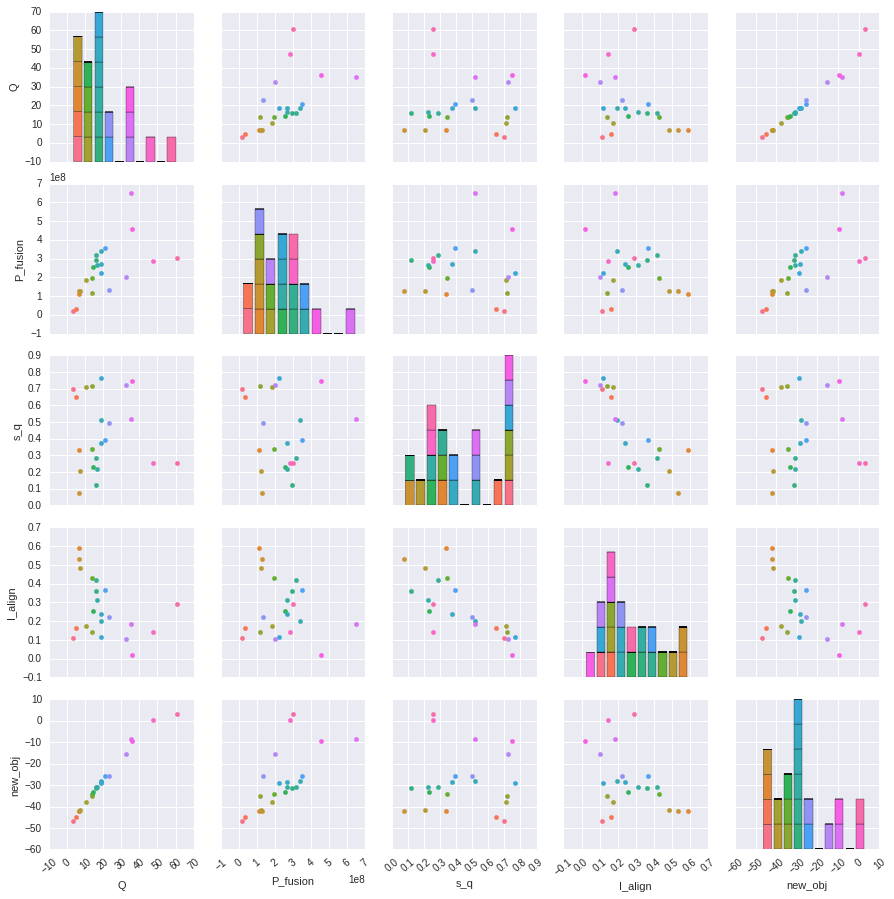

In [66]:
# with sns.plotting_context("talk"):
g = sns.PairGrid(df, vars=rows_obj + ['new_obj'], hue="Q",  
                 # palette=sns.color_palette("coolwarm", 14),
                 )
# g.map(plt.scatter)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
# g.set_xticklabels(rotation=30)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)

## Apply new objective to the Bayesian optimization object

In [67]:
# first replace objective in xmetis
xmetis.obj_func = obj_P_QCons
# and then apply to bo
bo.new_objective(xmetis)

Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loa

In [ ]:
# now try 50 iterations
bo.maximize(n_iter=50, **bo_params)

Bayesian Optimization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |         A |        B0 |      Enbi |      PEC0 |      PEC1 |      Pnbi |        R0 |      XEC0 |      XEC1 |     atang |     elong |      f_Gw |      qcyl |   t_ramp_up |    triang | 
Mem-cached the result, cache size: 44
   43 | 00m30s |  -35.60723 |    2.8109 |    7.2901 | 900979.5063 | 241067.7963 | 25285470.7879 | 82284516.5106 |    7.0697 |    0.5448 |    0.6289 |    0.3885 |    1.4313 |    0.8729 |    2.2798 |    127.2461 |    0.4056 | 
Mem-cached the result, cache size: 45
   44 | 00m24s |  -32.08856 |    2.5595 |    7.4620 | 505275.7287 | 75352.8590 | 13501900.6177 | 98990607.6568 |    7.1465 |    0.0347 |    0.1397 |    0.0898 |    1.7382 |    0.8246 |    2.2222 |    111.2757 |    0.3916 | 
Mem-cached the result, cache

In [69]:
bo.res['max']

{'max_params': {'A': 3.1420470232557816,
  'B0': 7.6000865747198976,
  'Enbi': 1453375.6946229865,
  'PEC0': 928444.69249946566,
  'PEC1': 28849019.130351633,
  'Pnbi': 29894838.768785164,
  'R0': 9.9023096693674564,
  'XEC0': 0.66202065254871212,
  'XEC1': 0.70280044069769232,
  'atang': 0.52386871795759316,
  'elong': 1.7355733916656857,
  'f_Gw': 1.0726624056147429,
  'qcyl': 2.3253412956762292,
  't_ramp_up': 149.68380675907991,
  'triang': 0.27395209142178489},
 'max_val': 3.4513318921372091}

### Save the results

In [70]:
# dill.dump(bo, open('bo_demo.pickle', 'wb'))

### Pandas again & plot

In [71]:
df2 = pd.DataFrame(bo.res['all']['params'])
posts_df2 = [xmetis(return_post=True, **p) for p in bo.res['all']['params']]
df2['objective'] = bo.res['all']['values']
df2.PEC1 = 1e-6 * df2.PEC1
df2.PEC0 = 1e-6 * df2.PEC0
df2.Pnbi = 1e-6 * df2.Pnbi
df2.Enbi = 1e-6 * df2.Enbi


Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loaded from mem cache :-]
Result loa

We add the iteration column (simply by indexing)

In [79]:
df2['iteration'] = np.ones(len(df2), dtype=np.int)
df2.loc[len(df):, 'iteration'] = 2

In [72]:
x_vars = list(df2.columns)
x_vars.remove('objective')

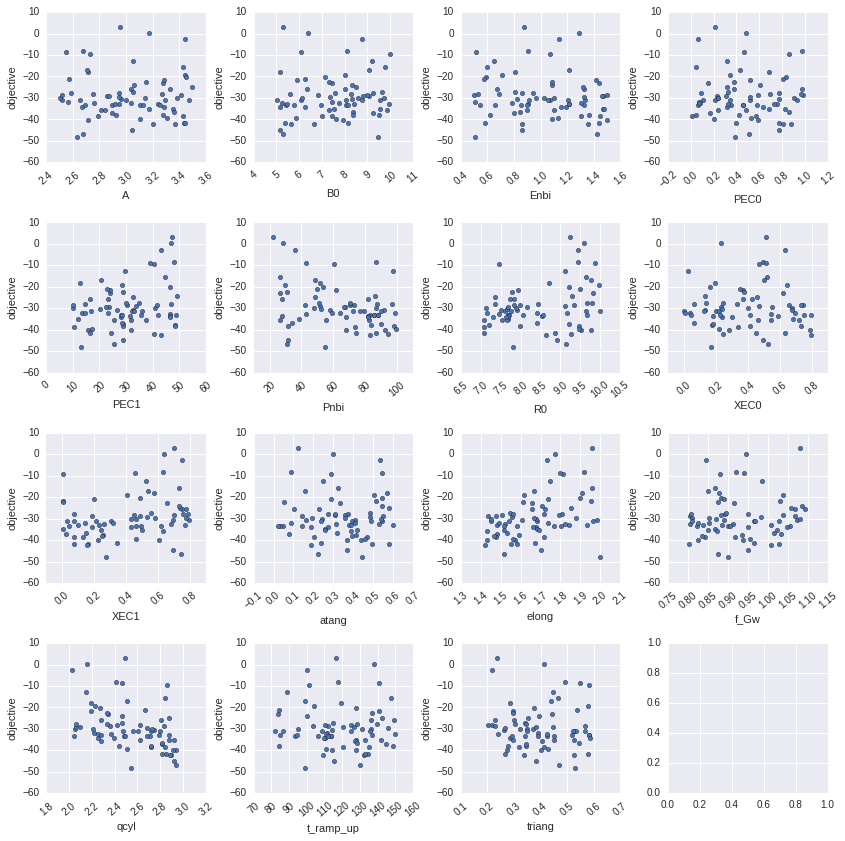

In [73]:
fig, axes = plt.subplots(int(np.ceil(len(x_vars) / 4)), 4, figsize=(14, 14))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
for ax, x in zip(axes.flat, x_vars):
    df2.plot.scatter(x=x, y='objective', ax=ax)
# for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)

In [74]:
df_new_objs2 = {
    's_q': obj_sq,
    'I_align': obj_ialign,
#     'flux': obj_flux,
    'P_fusion': obj_Pfusion,
    'Q': obj_Qfact,
}

In [75]:
for name, func in df_new_objs2.items():
    values = []
    for row, post in zip(df2.iterrows(), posts_df2):
#         params = row[1].to_dict()
        values.append(func(post))
#         print('.', end="")
    df2[name] = values

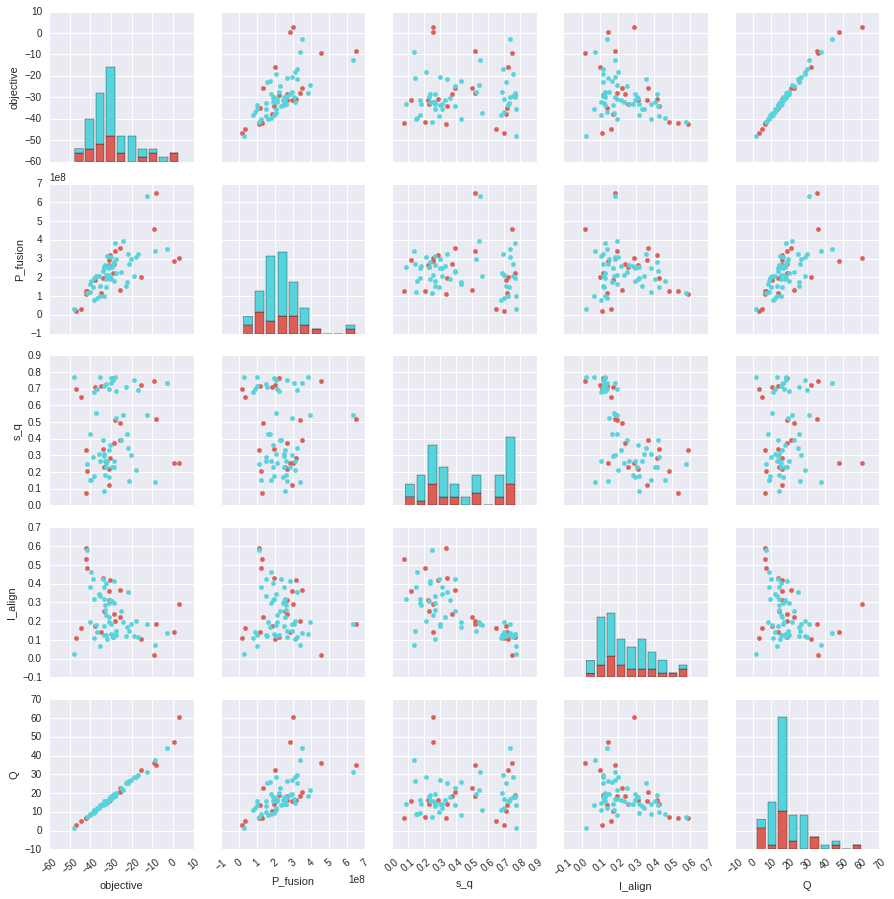

In [81]:
rows_obj = ['objective', 'P_fusion', 's_q', 'I_align', 'Q']
g = sns.PairGrid(df2, vars=rows_obj, 
#                  hue="objective",  
                 hue="iteration",  
                 palette=sns.color_palette("hls", 2),
                 )
# g.map(plt.scatter)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
# g.set_xticklabels(rotation=30)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)

In [83]:
df2_s = df2.sort_values('objective', ascending=False)

In [84]:
df2_s.iloc[:15][rows_obj + ['iteration']]

,objective,P_fusion,s_q,I_align,Q,iteration
2,3.024883,3.024883e+08,0.256742,0.293072,60.590365,1
11,0.325919,2.861301e+08,0.254487,0.144037,47.464618,1
46,-2.657936,3.508429e+08,0.734697,0.139473,43.833636,2
16,-8.266748,6.485753e+08,0.519623,0.185660,35.247499,1
64,-8.696942,3.379714e+08,0.138954,0.073561,37.923344,2
12,-9.384876,4.560643e+08,0.744218,0.020900,36.054481,1
34,-12.593089,6.352041e+08,0.545480,0.183006,31.054870,2
10,-15.631195,1.999703e+08,0.723818,0.104172,32.369101,1
61,-16.937335,3.259019e+08,0.694173,0.117345,29.803645,2
54,-18.080297,3.106295e+08,0.213627,0.202517,28.813408,2
